In [1]:
from pathlib import Path

from pysr import PySRRegressor

# other imports after pysr since it has to be before torch?
from jaxtyping import Float
import numpy as np
from zanj import ZANJ
import sympy as sp

from maze_dataset import MazeDatasetConfig
from maze_dataset.generation import LatticeMazeGenerators
from maze_dataset.benchmark.config_sweep import (
    SweepResult,
    full_percolation_analysis,
    dataset_success_fraction,
    plot_grouped,
)

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
# magic auto-reload
%load_ext autoreload
%autoreload

tqdm_allowed_kwargs = {'leave', 'delay', 'desc', 'self', 'nrows', 'smoothing', 'unit_divisor', 'unit_scale', 'write_bytes', 'gui', 'unit', 'ncols', 'lock_args', 'colour', 'position', 'total', 'file', 'mininterval', 'miniters', 'postfix', 'dynamic_ncols', 'maxinterval', 'ascii', 'disable', 'initial', 'bar_format', 'iterable'}
mapped_kwargs = {'total': 3, 'desc': 'Processing 3 items'}


Processing 3 items: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


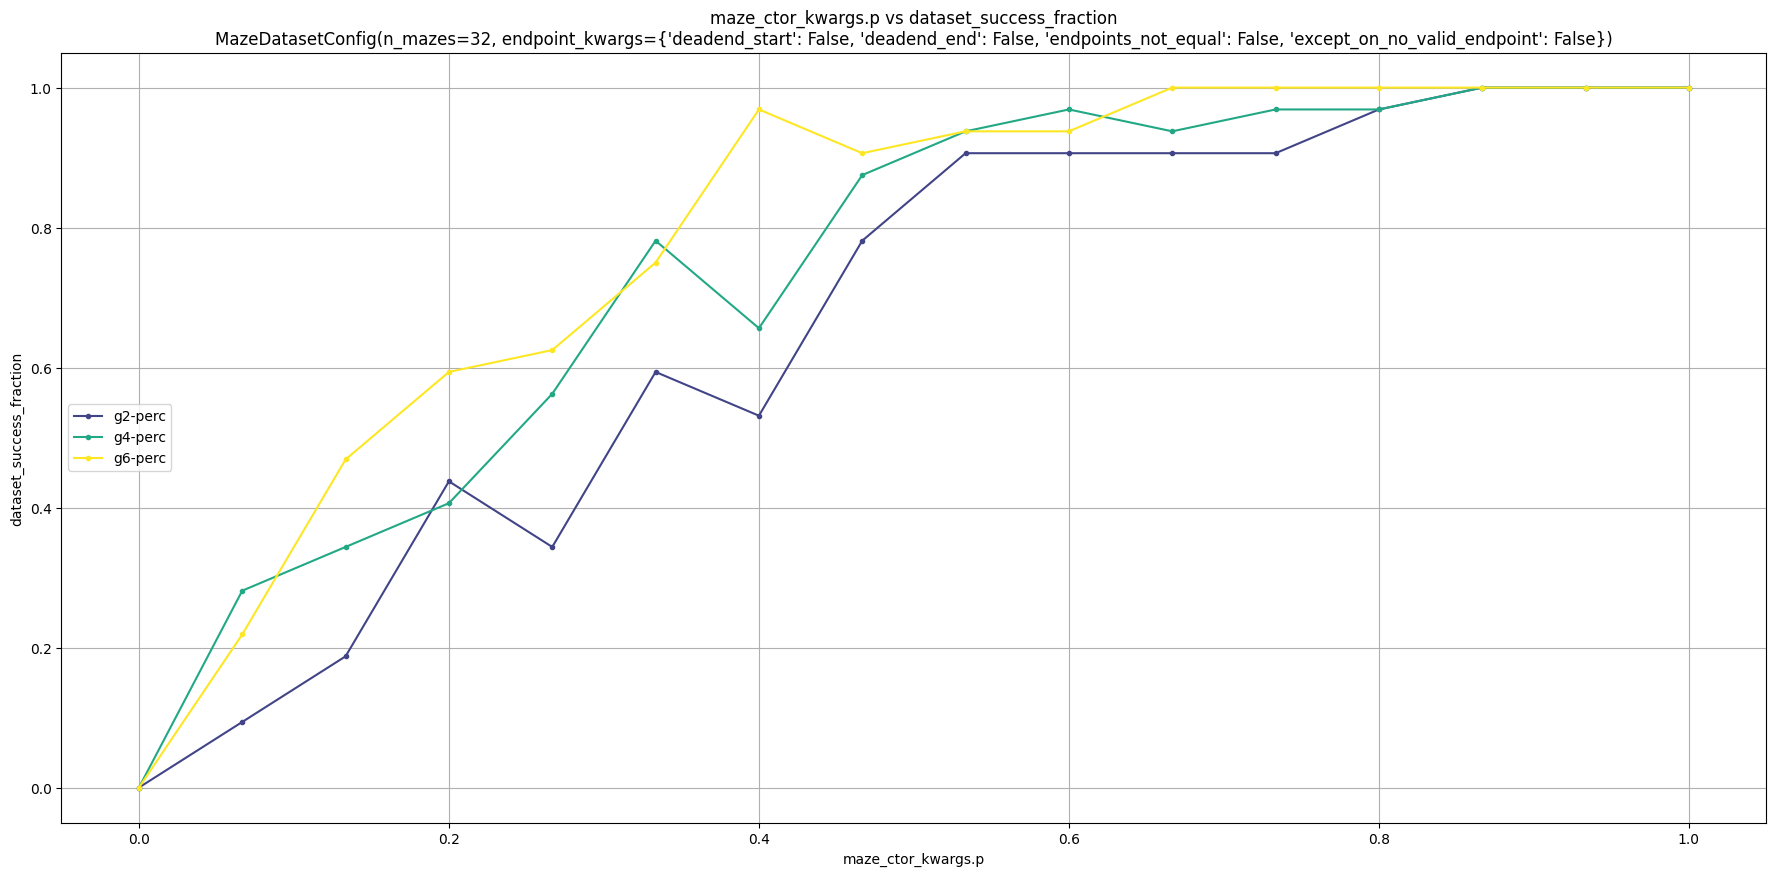

<Axes: title={'center': "maze_ctor_kwargs.p vs dataset_success_fraction\nMazeDatasetConfig(n_mazes=32, endpoint_kwargs={'deadend_start': False, 'deadend_end': False, 'endpoints_not_equal': False, 'except_on_no_valid_endpoint': False})"}, xlabel='maze_ctor_kwargs.p', ylabel='dataset_success_fraction'>

In [3]:
# Run the analysis
results: SweepResult = SweepResult.analyze(
    configs=[
        MazeDatasetConfig(
            name=f"g{grid_n}-perc",
            grid_n=grid_n,
            n_mazes=32,
            maze_ctor=LatticeMazeGenerators.gen_percolation,
            maze_ctor_kwargs=dict(),
            endpoint_kwargs=dict(
                deadend_start=False,
                deadend_end=False,
                endpoints_not_equal=False,
                except_on_no_valid_endpoint=False,
            ),
        )
        for grid_n in [2, 4, 6]
    ],
    param_values=np.linspace(0.0, 1.0, 16).tolist(),
    param_key="maze_ctor_kwargs.p",
    analyze_func=dataset_success_fraction,
    parallel=False,
)

# Plot results
results.plot(save_path=None, cfg_keys=["n_mazes", "endpoint_kwargs"])

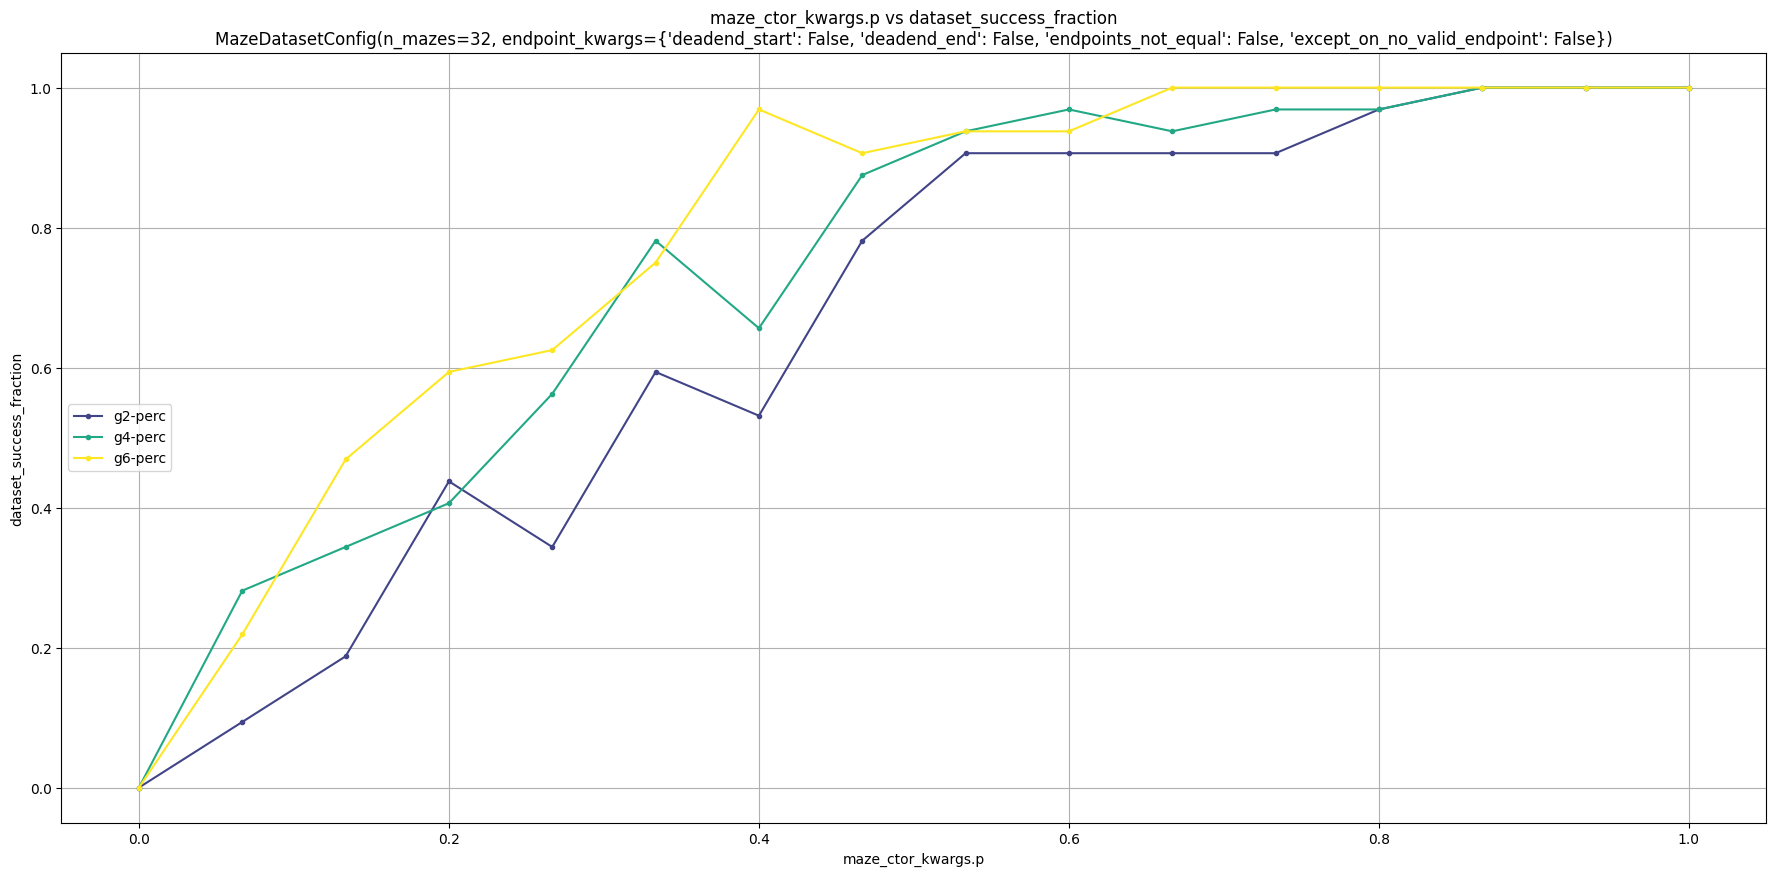

<Axes: title={'center': "maze_ctor_kwargs.p vs dataset_success_fraction\nMazeDatasetConfig(n_mazes=32, endpoint_kwargs={'deadend_start': False, 'deadend_end': False, 'endpoints_not_equal': False, 'except_on_no_valid_endpoint': False})"}, xlabel='maze_ctor_kwargs.p', ylabel='dataset_success_fraction'>

In [4]:
path = Path("../tests/_temp/dataset_frac_sweep/results_small.zanj")
results.save(path)
ZANJ().read(path).plot(cfg_keys=["n_mazes", "endpoint_kwargs"])

In [5]:
results_full: SweepResult = full_percolation_analysis(
    n_mazes=16,
    p_val_count=16,
    grid_sizes=[2, 4, 6],
    parallel=False,
)

tqdm_allowed_kwargs = {'leave', 'delay', 'desc', 'self', 'nrows', 'smoothing', 'unit_divisor', 'unit_scale', 'write_bytes', 'gui', 'unit', 'ncols', 'lock_args', 'colour', 'position', 'total', 'file', 'mininterval', 'miniters', 'postfix', 'dynamic_ncols', 'maxinterval', 'ascii', 'disable', 'initial', 'bar_format', 'iterable'}
mapped_kwargs = {'total': 18, 'desc': 'Processing 18 items'}


Processing 18 items: 100%|██████████| 18/18 [00:18<00:00,  1.02s/it]


Saving results to ../docs/benchmarks/percolation_fractions/result-n16-c18-p16.zanj


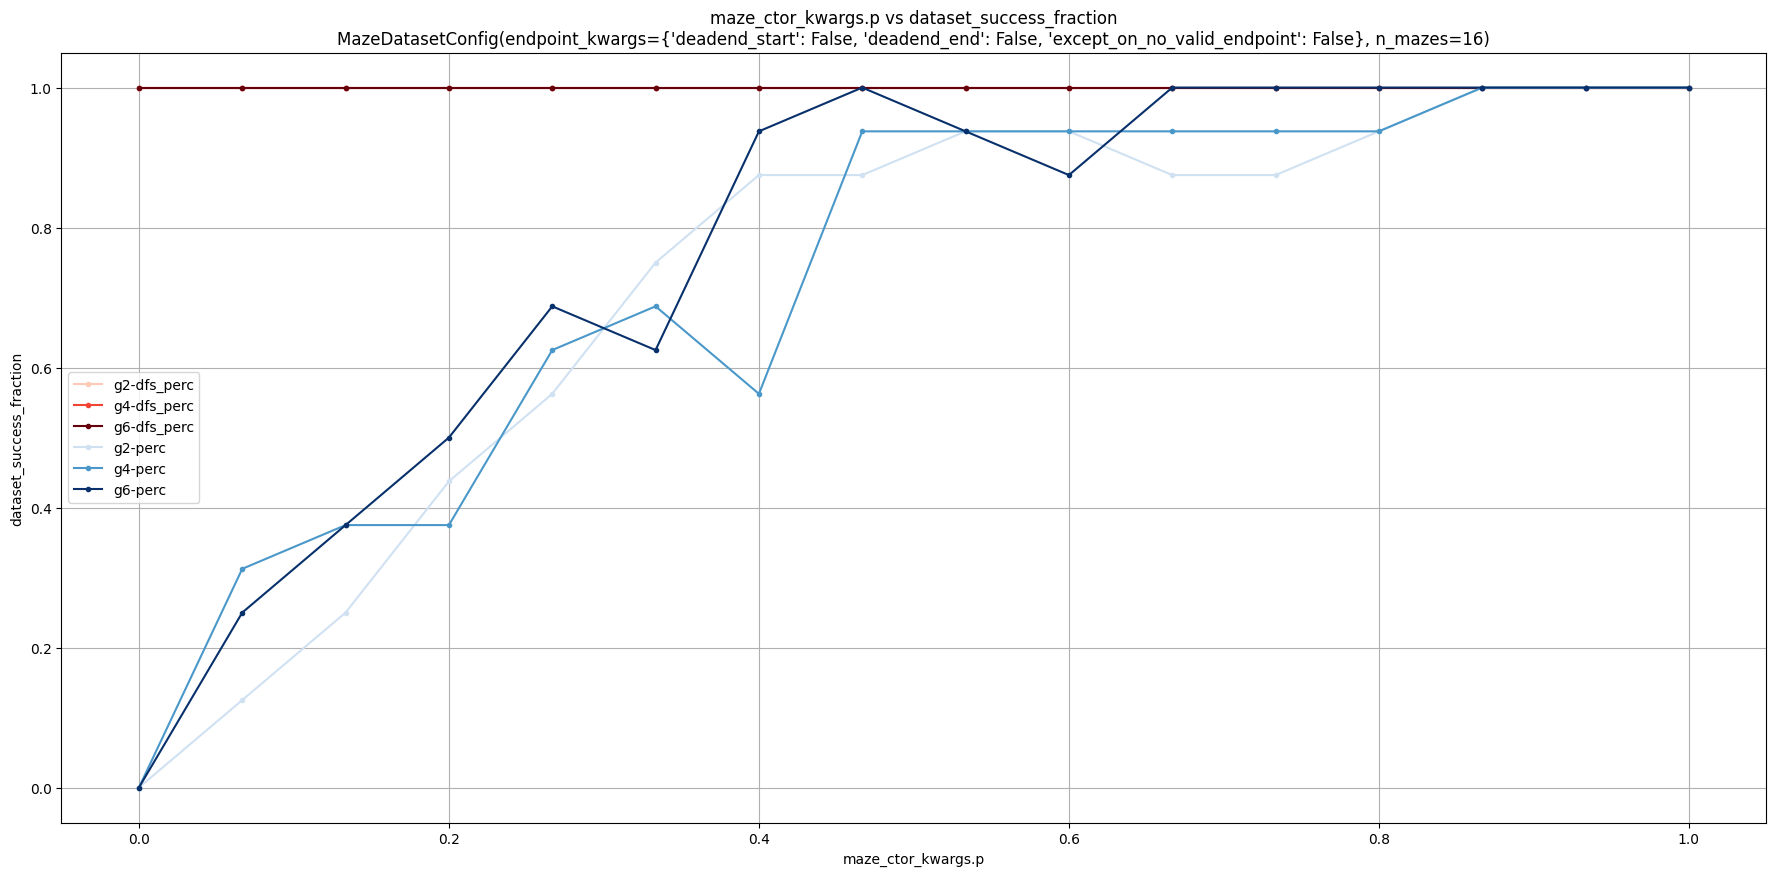

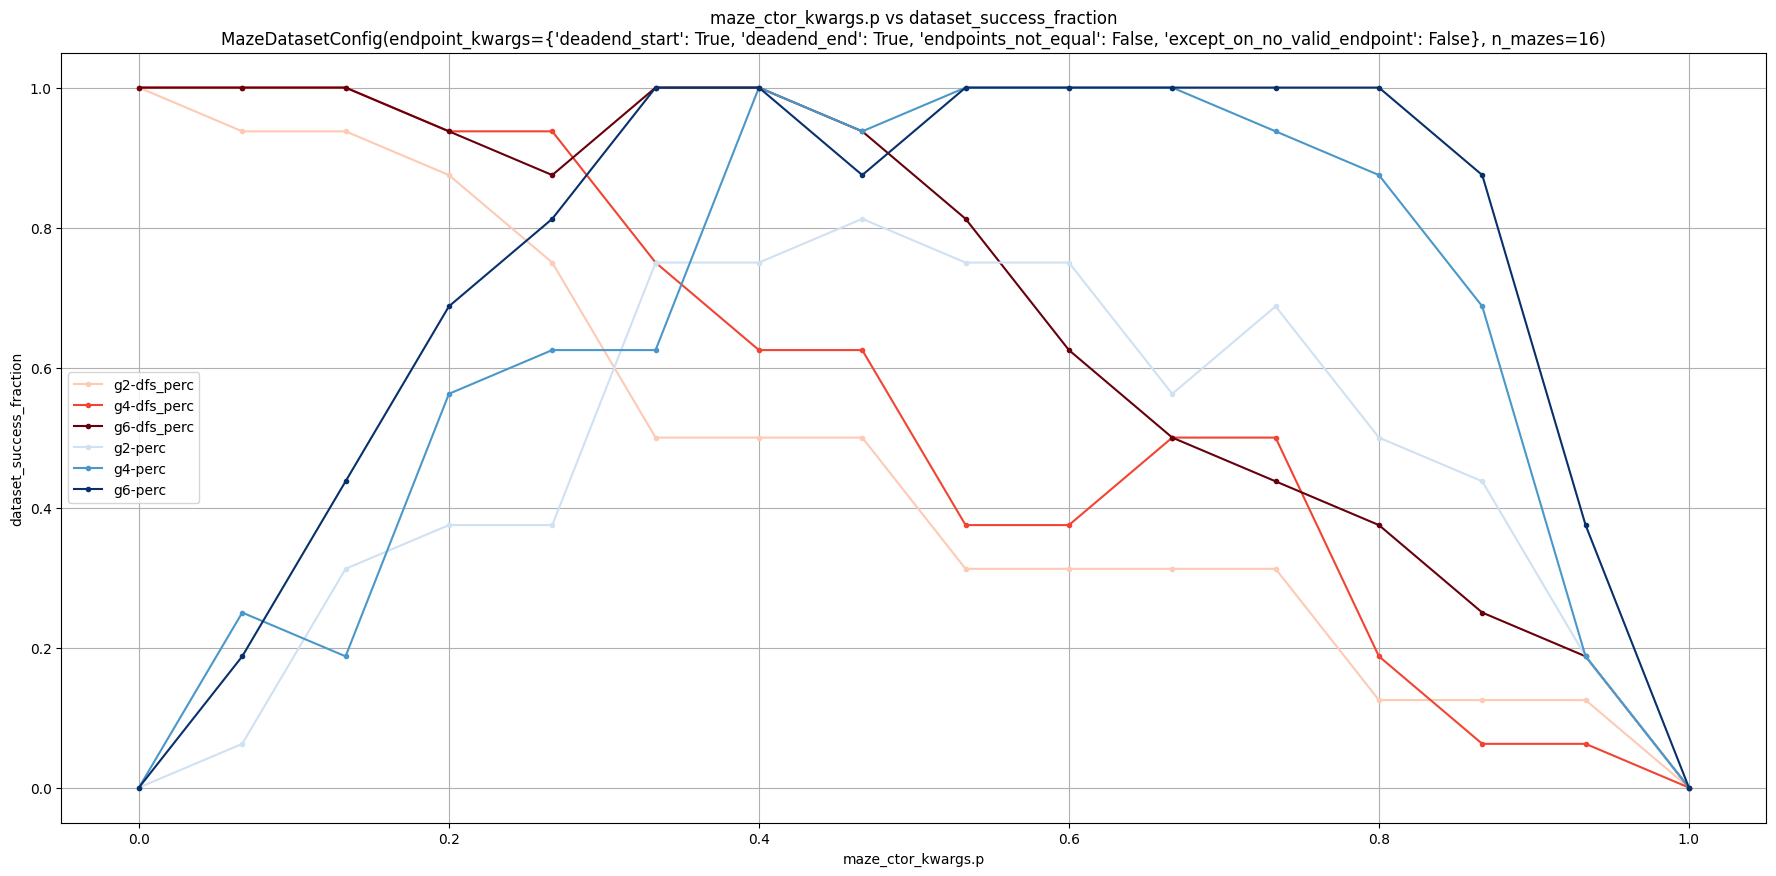

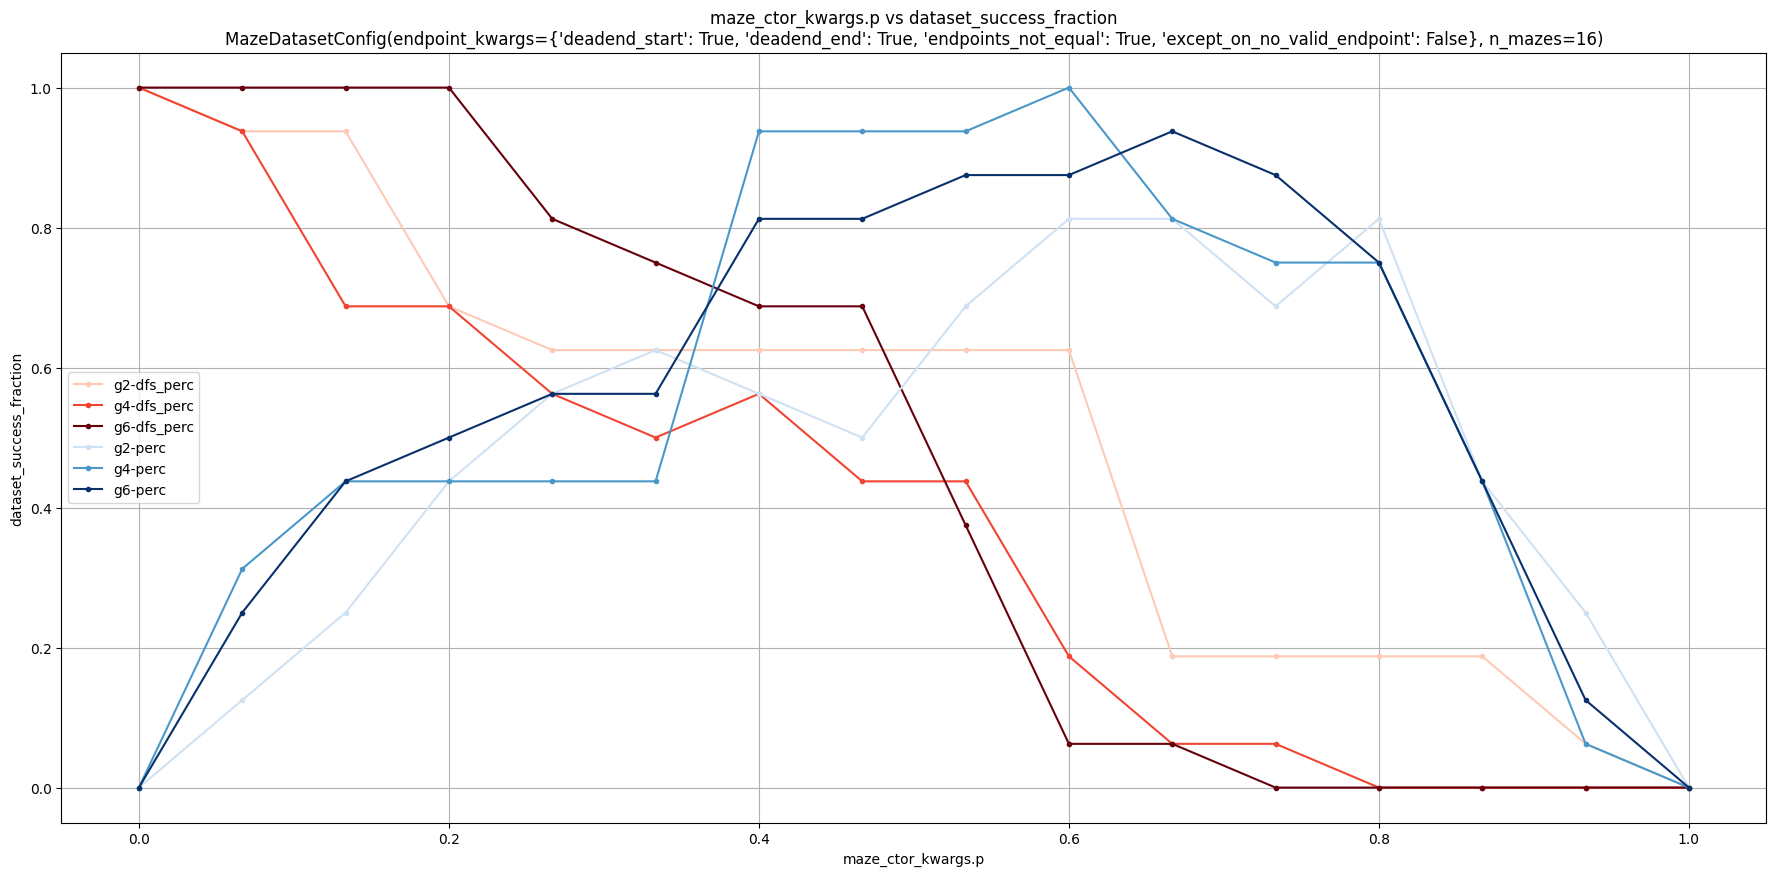

In [6]:
plot_grouped(results_full)

In [7]:
def extract_training_data(
    sweep_result: SweepResult,
) -> tuple[Float[np.ndarray, "num_rows 5"], Float[np.ndarray, " num_rows"]]:
    """Extract data (X, y) from a SweepResult.

    # Parameters:
     - `sweep_result : SweepResult`
        The sweep result holding configs and success arrays.

    # Returns:
     - `X : Float[np.ndarray, "num_rows 5"]`
        Stacked [p, grid_n, deadends, endpoints_not_equal, generator_func] for each config & param-value
     - `y : Float[np.ndarray, "num_rows"]`
        The corresponding success rate
    """
    X_list: list[list[float]] = []
    y_list: list[float] = []
    for cfg in sweep_result.configs:
        # success_arr is an array of success rates for param_values
        success_arr = sweep_result.result_values[cfg.to_fname()]
        for i, p in enumerate(sweep_result.param_values):
            # Temporarily override p in the config's array representation:
            arr = cfg._to_ps_array().copy()
            arr[0] = p  # index 0 is 'p'
            X_list.append(arr)
            y_list.append(success_arr[i])

    return np.array(X_list, dtype=np.float64), np.array(y_list, dtype=np.float64)

In [8]:

# RESULTS_LOADED: SweepResult = SweepResult.read("../docs/benchmarks/percolation_fractions/medium/result-n128-c42-p50.zanj")
RESULTS_LOADED: SweepResult = SweepResult.read("../docs/benchmarks/percolation_fractions/small/result-n64-c30-p25.zanj")
# RESULTS_LOADED: SweepResult = SweepResult.read("../docs/benchmarks/percolation_fractions/test/result-n16-c12-p16.zanj")


# Convert to arrays
X, y = extract_training_data(RESULTS_LOADED)

# Fit the PySR model
model = PySRRegressor(
    niterations=100,
    # Adjust operators as needed
    unary_operators=[
		"exp",
		"log",
		"inv(x) = 1/x",
        "square(x) = x^2",
        "cube(x) = x^3",
        "sigmoid(x) = 1/(1 + exp(-x))",
    ],
	extra_sympy_mappings={
        'inv': lambda x: 1/x,
        'square': lambda x: x**2,
        'cube': lambda x: x**3,
        'sigmoid': lambda x: 1/(1 + sp.exp(-x)),
    },
    binary_operators=["+", "-", "*", "/"],
    # If you want advanced features, specify them here:
    # e.g. select_k_features=4, population_size=1000, etc.
    progress=True,
    model_selection="best",
)
model.fit(X, y)



f:\KNC\maze-dataset\.venv\Lib\site-packages\pysr\sr.py:2780: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Compiling Julia backend...


[ Info: Started!



Expressions evaluated per second: 6.870e+04
Progress: 421 / 3100 total iterations (13.581%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.151e-01  1.594e+01  y = 0.65075
3           1.143e-01  3.755e-03  y = sigmoid(sigmoid(x₃))
4           9.469e-02  1.880e-01  y = sigmoid(1.2878 - x₂)
5           9.190e-02  2.990e-02  y = sigmoid(square(x₂ + -1.3884))
6           8.408e-02  8.895e-02  y = exp(-0.15954 - (x₀ * x₂))
7           7.888e-02  6.382e-02  y = exp(-0.27103 - (x₂ * cube(x₀)))
9           6.719e-02  8.019e-02  y = 1.7192 - exp((x₂ - 0.54184) * square(x₀))
16          6.393e-02  7.117e-03  y = sigmoid(log(square((-0.38119 - (x₄ - (x₂ * x₀))) - ((x...
                                      ₀ - x₂) * 3.1687))))
17          5.682e-02  1.178e-01  y = sigmoid(square((-0.38119

[ Info: Final population:
[ Info: Results saved to:


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                           0.650753   
	1         0.003755                               sigmoid(sigmoid(x3))   
	2         0.208995                           0.41565064 / sigmoid(x2)   
	3         0.009224                     0.86644584 - (x2 * 0.32355958)   
	4         0.112786                       0.86644584 - (x2 * cube(x0))   
	5         0.069604                 sigmoid(1.922352 - (exp(x0) * x2))   
	6         0.050365          sigmoid(1.5909201 - (x2 * exp(cube(x0))))   
	7         0.092940       1.7199247 - exp((x2 - 0.4836283) * cube(x0))   
	8         0.101121  sigmoid(x0 * (5.377243 - ((x0 * 7.382482) * x2)))   
	9         0.016282     sigmoid(((1.610193 - x0) - x2) * exp(x4 + x0))   
	10        0.303549  sigmoid((((1.6285493 - x0) - x2) * (x0 + x4)) ...   
	11        0.057101  sigmoid((((1.6276841 - x0) - x2) * 4.298011) *...   
	12        0.180563  sigmoid((x0 - (0.24018422 - x4)) * (((1.628080...   
	13        0.280510  sigmoid(1.3755696 - (((0.42574096 - (x0 * x2))...   
	14        0.104208  sigmoid((((0.39195174 - (x0 * x2)) * ((sigmoid...   
	15        0.081764  sigmoid((x0 - (((0.40432268 - x0) - x4) * (1.5...   
	16        0.057968  sigmoid((x0 - ((log(1.4577812 - x0) - x4) * (1...   
	17  >>>>  0.309802  sigmoid((x0 - ((1.5570555 - (x0 * (x3 + (x2 * ...   
	18        0.115492  sigmoid(x1 * (x0 - (((0.2981735 - square(x0)) ...   
	19        0.012268  sigmoid((x1 * (x0 - (((0.2981735 - square(x0))...   
	20        0.038379  sigmoid((x0 - (((0.41992965 - x0) - cube(x4 - ...   
	21        0.054299  sigmoid(x1 * (x0 - (((0.518538 - x0) - (cube(s...   
	22        0.000040  sigmoid((x0 - ((((0.49940684 - x0) - (exp(x4) ...   
	
	        loss  complexity  
	0   0.115136           1  
	1   0.114274           3  
	2   0.092722           4  
	3   0.091871           5  
	4   0.082072           6  
	5   0.076554           7  
	6   0.072794           8  
	7   0.066333           9  
	8   0.059953          10  
	9   0.058985          11  
	10  0.043542          12  
	11  0.041126          13  
	12  0.034332          14  
	13  0.019591          16  
	14  0.017652          17  
	15  0.016266          18  
	16  0.015350          19  
	17  0.011261          20  
	18  0.010032          21  
	19  0.009789          23  
	20  0.009066          25  
	21  0.008133          27  
	22  0.008132          29  
]

Best PySR Equation: model.get_best()['equation'] = 'sigmoid((x0 - ((1.5570555 - (x0 * (x3 + (x2 * 3.3981435)))) * ((0.41547063 - x0) - x4))) * 2.9682653)'
predict_fn =PySRFunction(X=>1/(1 + exp(-1*(x0 - (1.5570555 - x0*(x2*3.3981435 + x3))*(-x0 - x4 + 0.41547063))*2.9682653)))
Best PySR Equation: sigmoid((x0 - ((1.5570555 - (x0 * (x3 + (x2 * 3.3981435)))) * ((0.41547063 - x0) - x4))) * 2.9682653)
Predicted success rate for test_config: 0.691904582036378


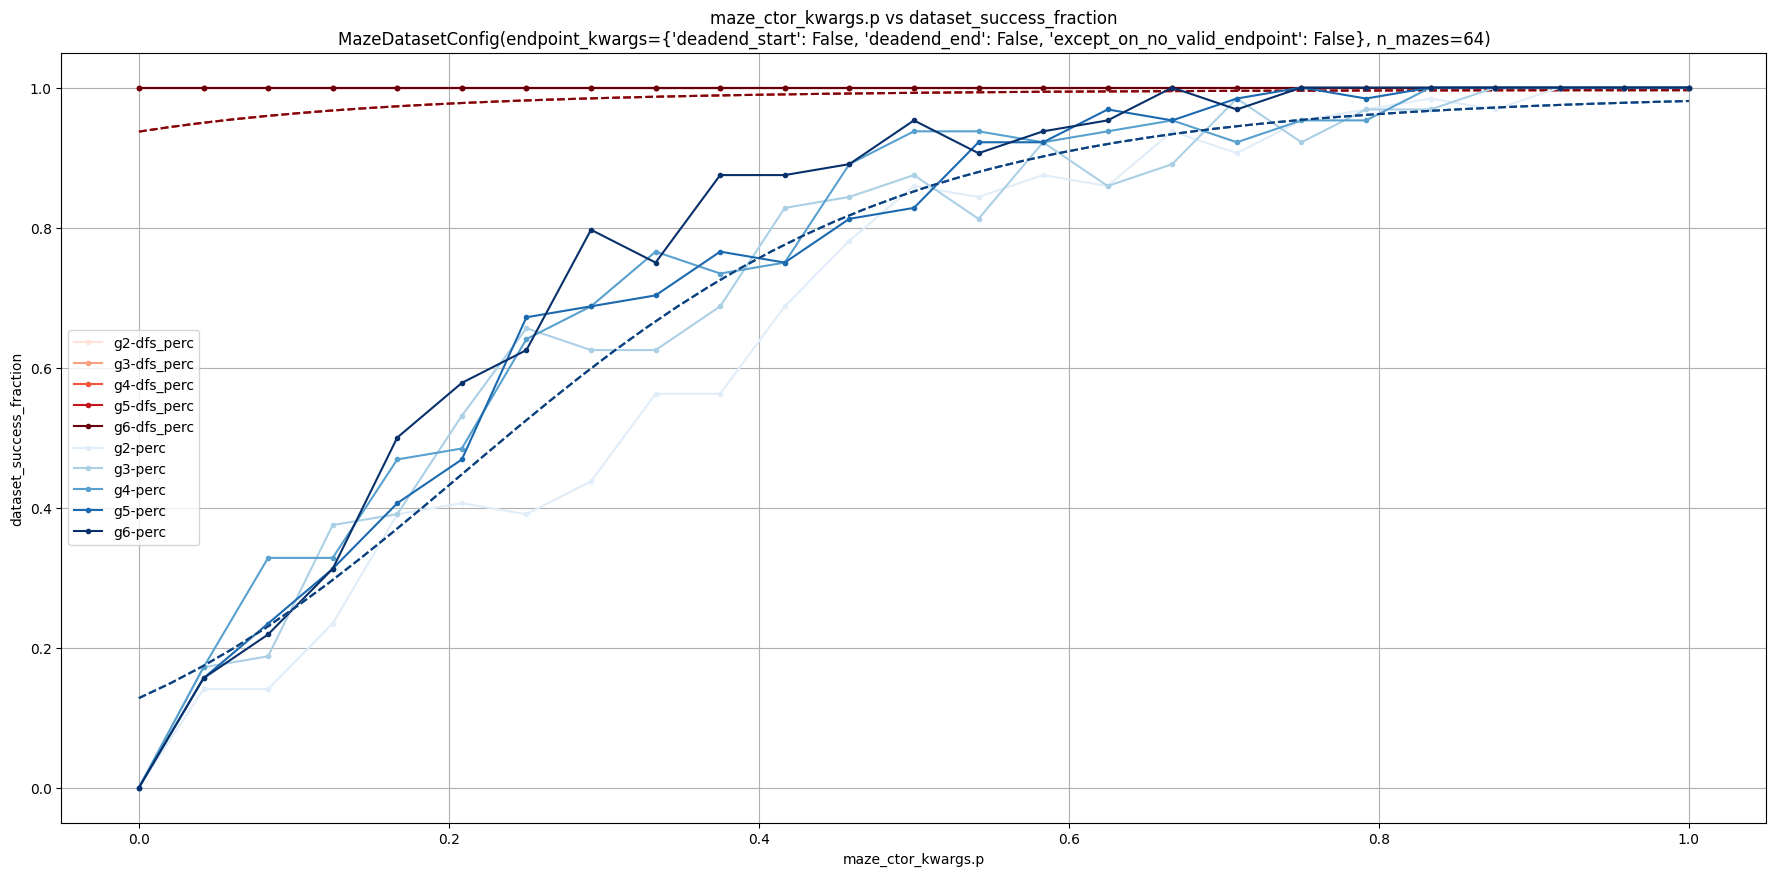

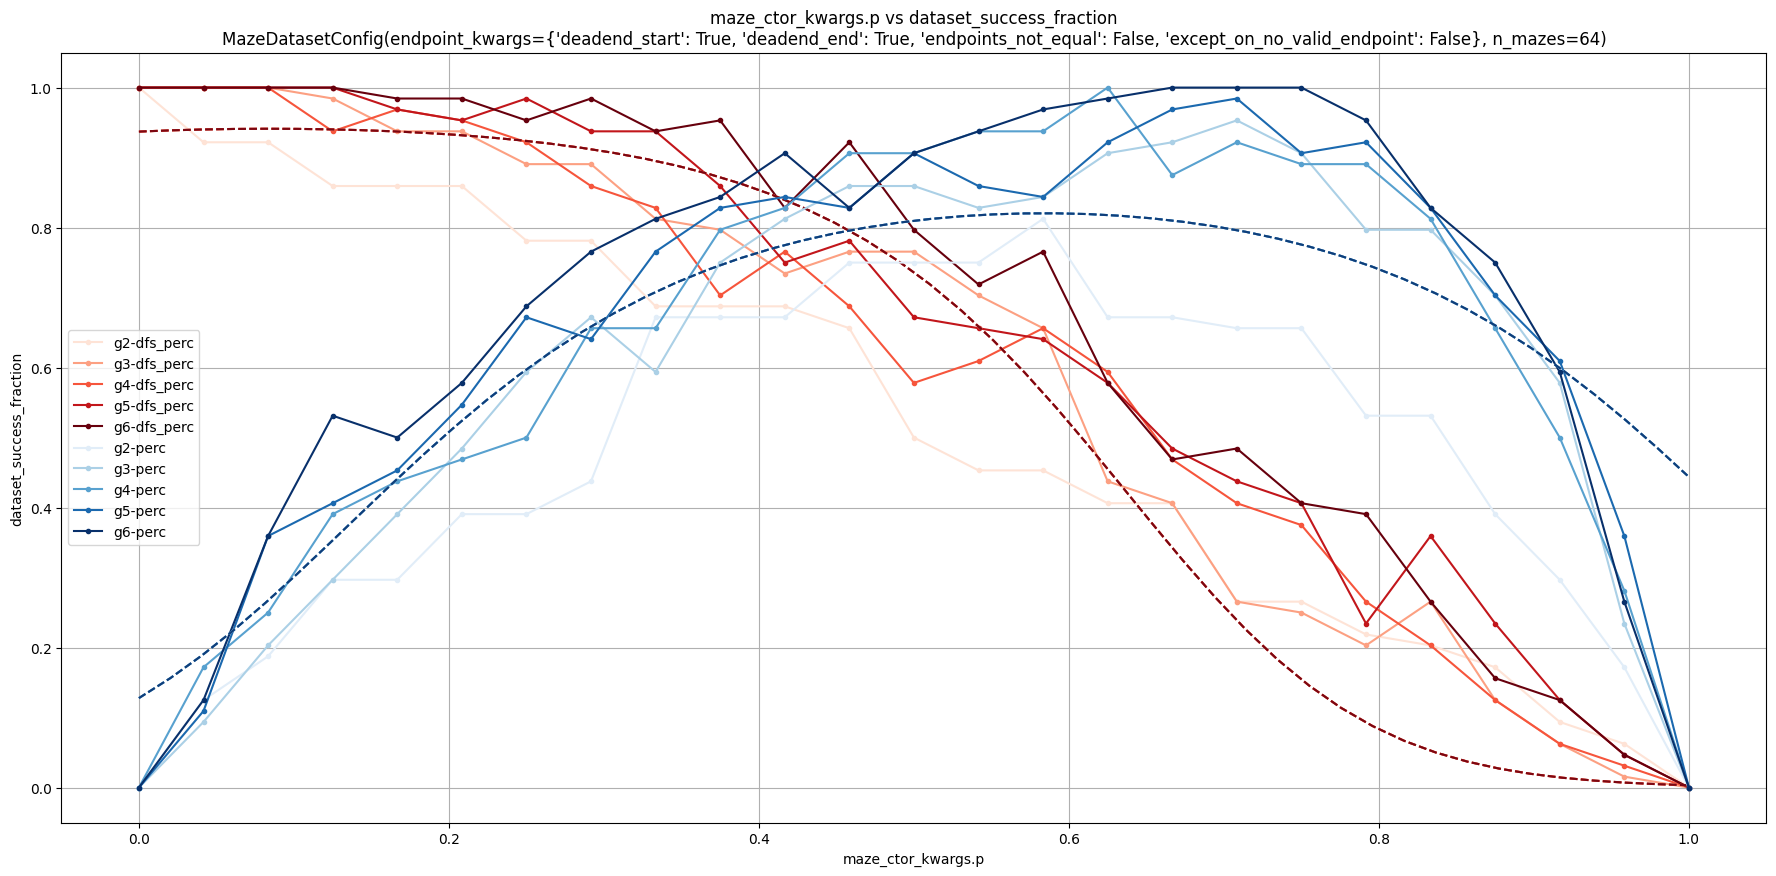

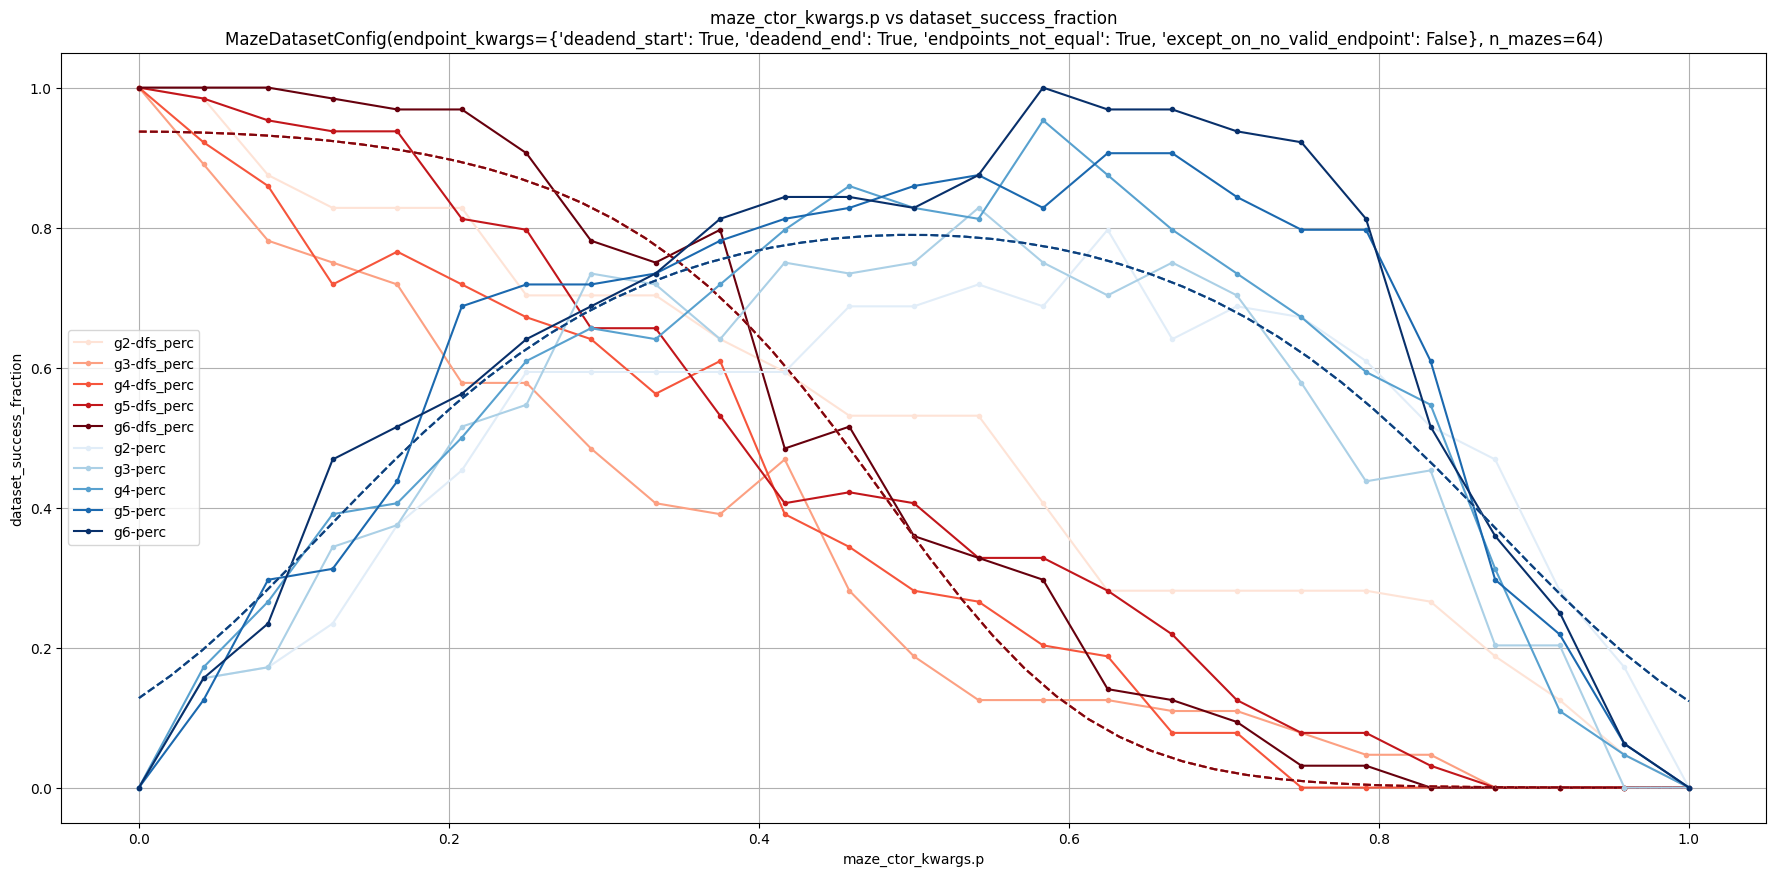

In [9]:


# Create a callable that predicts from MazeDatasetConfig
predict_fn = model.get_best()["lambda_format"]
print(f"Best PySR Equation: {model.get_best()['equation'] = }")
print(f"{predict_fn =}")

def predict_config(cfg: MazeDatasetConfig) -> float:
    arr = cfg._to_ps_array()
    result = predict_fn(arr)[0]
    return float(result)  # pass the array as separate args

# Example new config
test_config = MazeDatasetConfig(
    name="some_test",
    grid_n=16,
    n_mazes=100,
    maze_ctor=LatticeMazeGenerators.gen_percolation,
    maze_ctor_kwargs={"p": 0.3},
    endpoint_kwargs={
        "deadend_start": True,
        "deadend_end": True,
        "endpoints_not_equal": True,
        "except_on_no_valid_endpoint": False,
    },
)
predicted_rate = predict_config(test_config)
print("Best PySR Equation:", model.get_best()["equation"])
print("Predicted success rate for test_config:", predicted_rate)


plot_grouped(RESULTS_LOADED, predict_fn=predict_config)